In [1]:
import pandas                          as      pd
import numpy                           as      np
import matplotlib.pyplot               as      plt
import statsmodels.tools.eval_measures as      em
from   sklearn.metrics                 import  mean_squared_error
from   statsmodels.tsa.api             import ExponentialSmoothing, SimpleExpSmoothing, Holt
from   IPython.display                 import display
from   pylab                           import rcParams

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from sklearn.metrics import  mean_squared_error

import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

### 1.Read the data as an appropriate Time Series data and plot the data.

In [2]:
dfr = pd.read_csv('Rose.csv',parse_dates=['YearMonth'],index_col='YearMonth')

In [3]:
dfr.head()

,Rose
YearMonth,
1980-01-01,112.0
1980-02-01,118.0
1980-03-01,129.0
1980-04-01,99.0
1980-05-01,116.0


In [4]:
rcParams['figure.figsize'] = 14,7

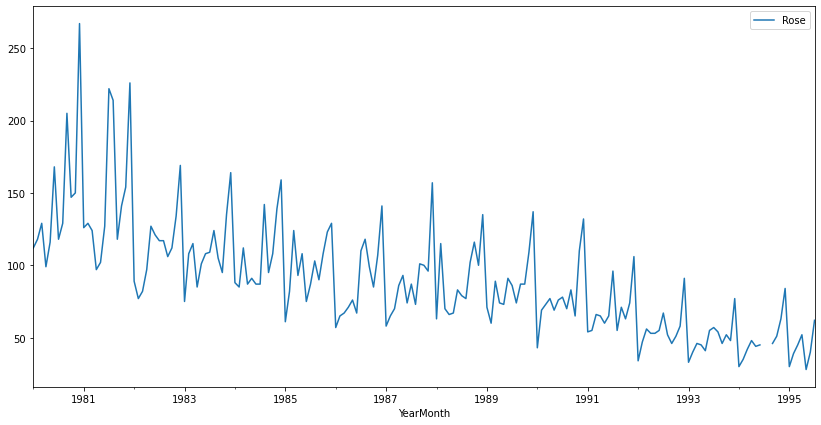

In [5]:
dfr.plot();

### 2.Perform appropriate Exploratory Data Analysis to understand the data and also perform decomposition.

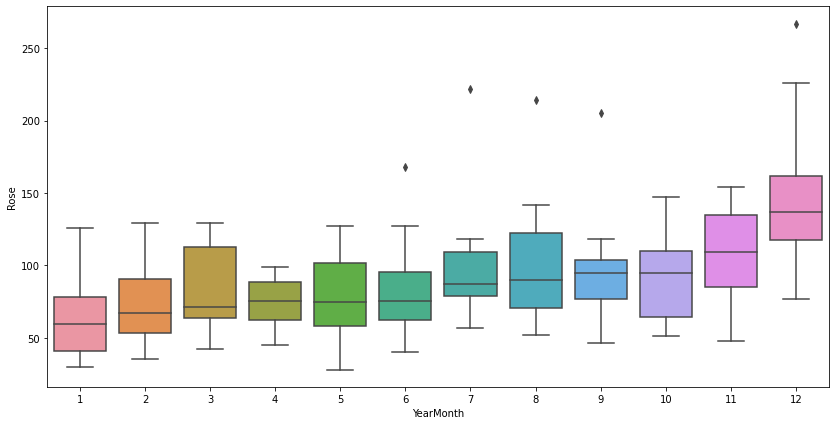

In [6]:
#Variation of Rose wines across Months
sns.boxplot(x=dfr.index.month,y=dfr['Rose']);

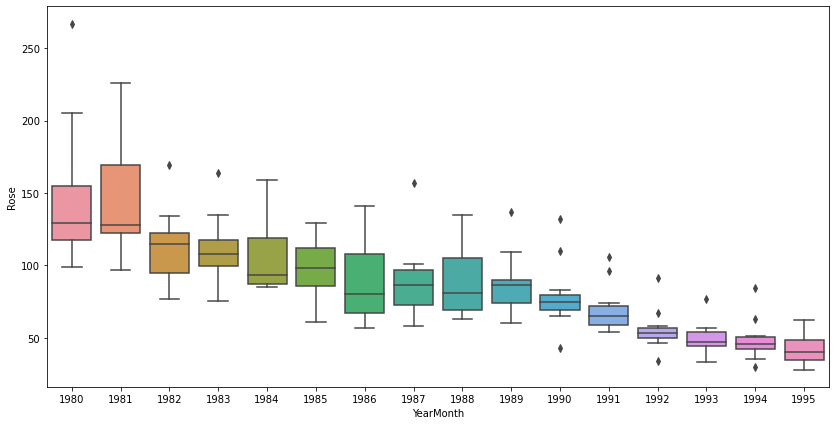

In [7]:
#Variation of Rose wines across years
sns.boxplot(x=dfr.index.year,y=dfr['Rose']);

Bivariate Analysis

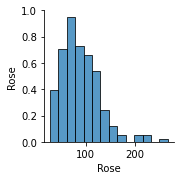

In [8]:
sns.pairplot(dfr);

In [9]:
dfr.isnull().sum()

Rose    2
dtype: int64

In [10]:
dfr_new=dfr.interpolate()

In [11]:
dfr_new.isnull().sum()

Rose    0
dtype: int64

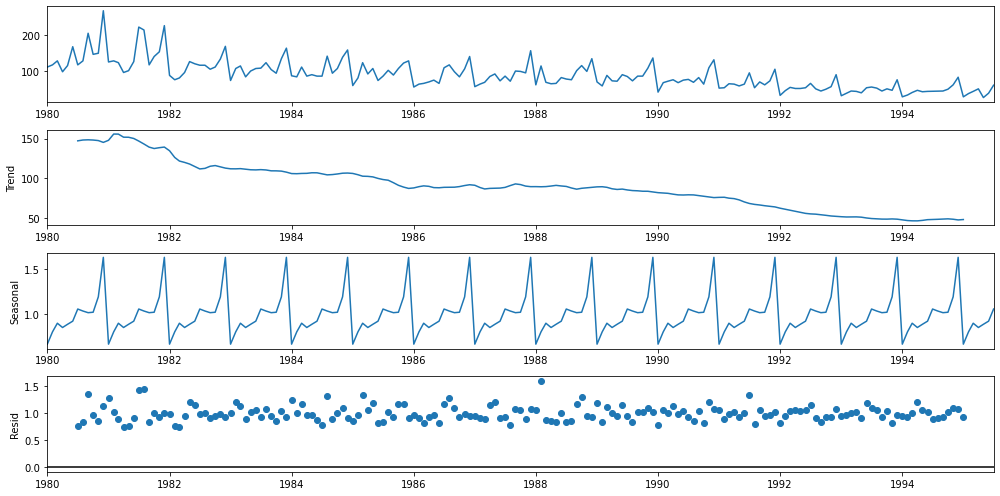

In [12]:
deco_rnew = seasonal_decompose(dfr_new,model='multiplicative')
deco_rnew.plot();

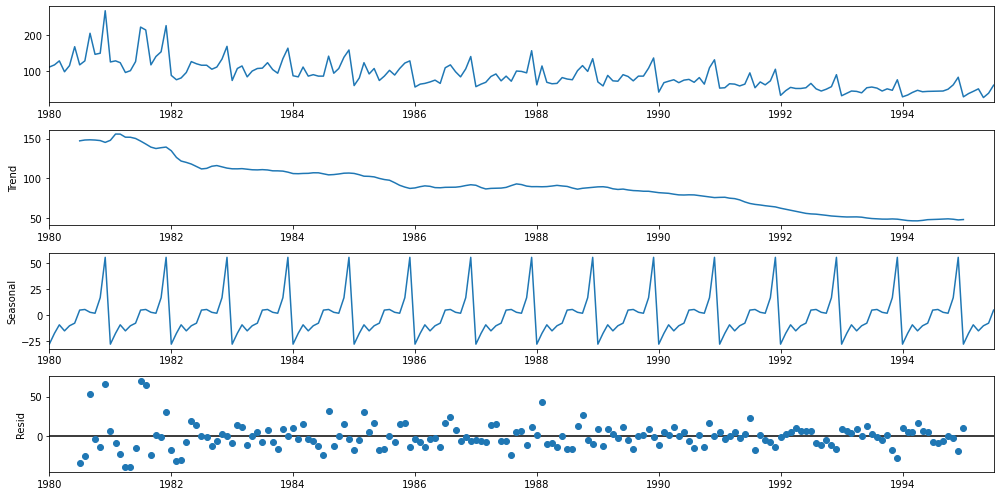

In [13]:
deco_rnew = seasonal_decompose(dfr_new,model='additive')
deco_rnew.plot();

Upon observation of the residual, multiplicative decomposition suits the data series.
### 3.Split the data into training and test. The test data should start in 1991.

In [14]:
train_rose   =   dfr_new[0:int(len(dfr_new)*0.71)] 
test_rose    =   dfr_new[int(len(dfr_new)*0.71):]

In [15]:
print(train_rose.head(),'\n')
print(train_rose.tail(),'\n\n')
print(test_rose.head(),'\n')
print(test_rose.tail(),'\n')

             Rose
YearMonth        
1980-01-01  112.0
1980-02-01  118.0
1980-03-01  129.0
1980-04-01   99.0
1980-05-01  116.0 

             Rose
YearMonth        
1990-08-01   70.0
1990-09-01   83.0
1990-10-01   65.0
1990-11-01  110.0
1990-12-01  132.0 


            Rose
YearMonth       
1991-01-01  54.0
1991-02-01  55.0
1991-03-01  66.0
1991-04-01  65.0
1991-05-01  60.0 

            Rose
YearMonth       
1995-03-01  45.0
1995-04-01  52.0
1995-05-01  28.0
1995-06-01  40.0
1995-07-01  62.0 



### 4. Build various exponential smoothing models on the training data and evaluate the model using RMSE on the test data.Other models such as regression,naïve forecast models, simple average models etc. should also be built on the training data and check the performance on the test data using RMSE.

#### 1.1) Linear Regression

In [16]:
train_time = [i+1 for i in range(len(train_rose))]
test_time = [i+133 for i in range(len(test_rose))]

lr_train_rose = train_rose.copy()
lr_test_rose = test_rose.copy()
lr_train_rose['time'] = train_time
lr_test_rose['time'] = test_time
lr_train_rose.head()

lr = LinearRegression()
lr.fit(lr_train_rose[['time']],lr_train_rose['Rose'])

train_rose_pred_mod_lr     = lr.predict(lr_train_rose[['time']])
lr_train_rose['RegOnTime'] = train_rose_pred_mod_lr

test_rose_pred_mod_lr     = lr.predict(lr_test_rose[['time']])
lr_test_rose['RegOnTime'] = test_rose_pred_mod_lr

In [17]:
lr_rmse_mod_test_rose = mean_squared_error(lr_test_rose['Rose'], test_rose_pred_mod_lr, squared=False)
rw_rmse = pd.DataFrame({'RMSE': [lr_rmse_mod_test_rose]},index=['Linear Regression'])
rw_rmse

,RMSE
Linear Regression,15.268955


#### 1.2) Naive

In [18]:
nm_train_rose = train_rose.copy()
nm_test_rose = test_rose.copy()

nm_test_rose['naive'] = np.asarray(train_rose['Rose'])[len(np.asarray(train_rose['Rose']))-1]

In [19]:
nm_rmse_mod_test_rose = metrics.mean_squared_error(test_rose['Rose'], nm_test_rose['naive'],squared=False)
temp_rw_rmse = pd.DataFrame({'RMSE': [nm_rmse_mod_test_rose]},index=['Naive Model'])
rw_rmse = pd.concat([rw_rmse, temp_rw_rmse])
rw_rmse

,RMSE
Linear Regression,15.268955
Naive Model,79.718773


#### 1.3) Simple Average

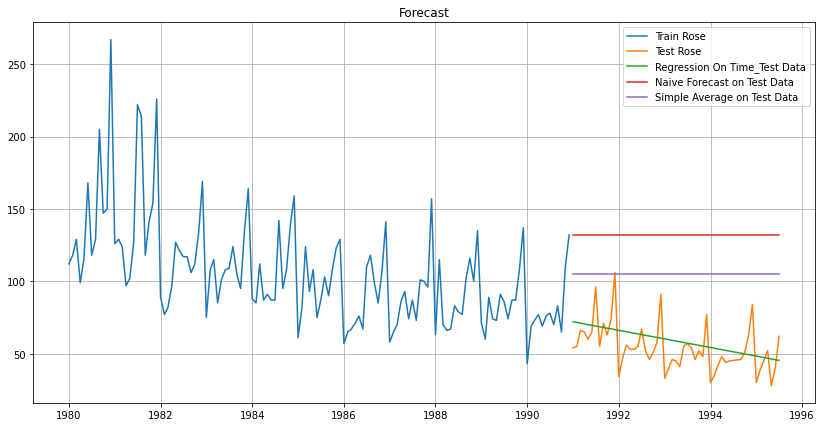

In [20]:
sa_train_rose = train_rose.copy()
sa_test_rose = test_rose.copy()

sa_test_rose['mean_forecast'] = train_rose['Rose'].mean()

plt.plot(sa_train_rose['Rose'], label='Train Rose')
plt.plot(sa_test_rose['Rose'], label='Test Rose')

plt.plot(lr_test_rose['RegOnTime'], label='Regression On Time_Test Data')
plt.plot(nm_test_rose['naive'], label='Naive Forecast on Test Data')
plt.plot(sa_test_rose['mean_forecast'], label='Simple Average on Test Data')

plt.legend(loc='best')
plt.title("Forecast")
plt.grid();

In [21]:
sa_rmse_mod_test_rose = metrics.mean_squared_error(test_rose['Rose'], sa_test_rose['mean_forecast'],squared=False)
temp_rw_rmse = pd.DataFrame({'RMSE': [sa_rmse_mod_test_rose]},index=['Simple Average'])
rw_rmse = pd.concat([rw_rmse, temp_rw_rmse])
rw_rmse

,RMSE
Linear Regression,15.268955
Naive Model,79.718773
Simple Average,53.460570


#### 1.4) Moving Average

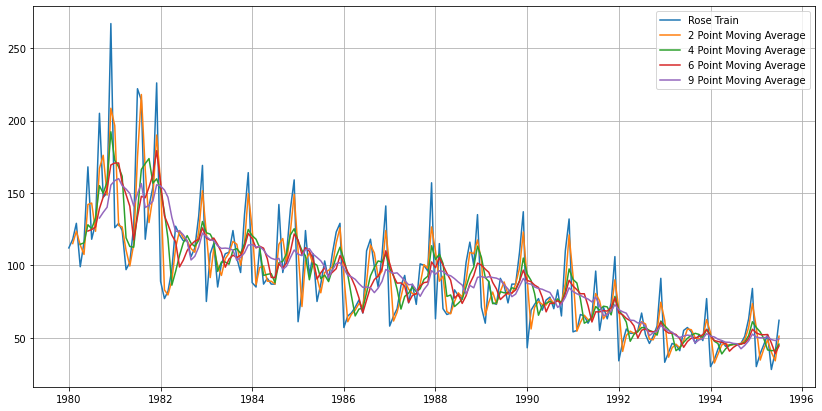

In [22]:
ma_rose = dfr_new.copy()

ma_rose['Trailing_2'] = ma_rose['Rose'].rolling(2).mean()
ma_rose['Trailing_4'] = ma_rose['Rose'].rolling(4).mean()
ma_rose['Trailing_6'] = ma_rose['Rose'].rolling(6).mean()
ma_rose['Trailing_9'] = ma_rose['Rose'].rolling(9).mean()

plt.plot(ma_rose['Rose'], label='Rose Train')
plt.plot(ma_rose['Trailing_2'], label='2 Point Moving Average')
plt.plot(ma_rose['Trailing_4'], label='4 Point Moving Average')
plt.plot(ma_rose['Trailing_6'], label = '6 Point Moving Average')
plt.plot(ma_rose['Trailing_9'], label = '9 Point Moving Average')

plt.legend(loc = 'best')
plt.grid();

In [23]:
#Creating train & test set 
ma_train_rose  = ma_rose[ma_rose.index<'1991']
ma_test_rose   = ma_rose[ma_rose.index>='1991']

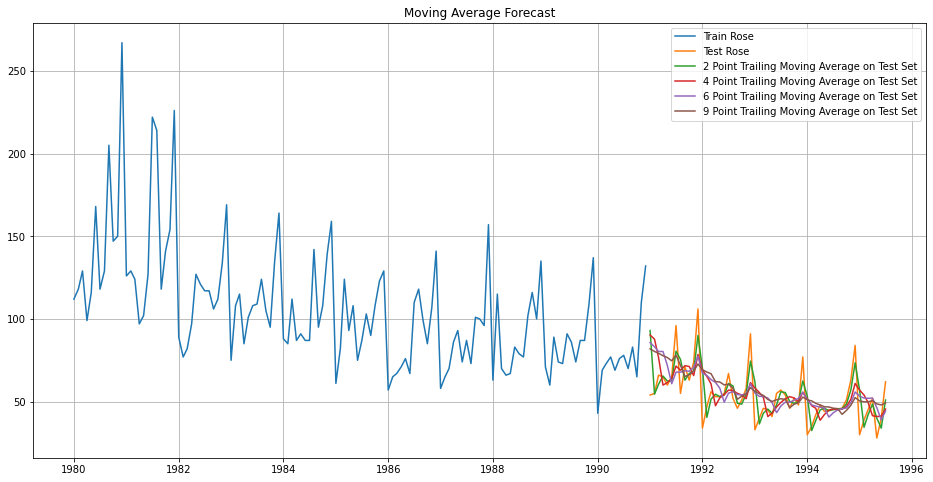

In [24]:
## Plotting on both the Training and Test data
plt.figure(figsize=(16,8))
plt.plot(ma_train_rose['Rose'], label='Train Rose')
plt.plot(ma_test_rose['Rose'], label='Test Rose')

plt.plot(ma_test_rose['Trailing_2'], label='2 Point Trailing Moving Average on Test Set')
plt.plot(ma_test_rose['Trailing_4'], label='4 Point Trailing Moving Average on Test Set')
plt.plot(ma_test_rose['Trailing_6'], label = '6 Point Trailing Moving Average on Test Set')
plt.plot(ma_test_rose['Trailing_9'], label = '9 Point Trailing Moving Average on Test Set')

plt.legend(loc = 'best')
plt.title("Moving Average Forecast")
plt.grid();

In [25]:
## Test Data - RMSE for Trailing Moving Average

# 2 Point
ma_rmse_mod_test_rose_2 = metrics.mean_squared_error(test_rose['Rose'], ma_test_rose['Trailing_2'],squared=False)
temp_rw_rmse = pd.DataFrame({'RMSE': [ma_rmse_mod_test_rose_2]},index=['2 Point Moving Average'])
rw_rmse = pd.concat([rw_rmse, temp_rw_rmse])
rw_rmse

# 4 Point
ma_rmse_mod_test_rose_4 = metrics.mean_squared_error(test_rose['Rose'], ma_test_rose['Trailing_4'],squared=False)
temp_rw_rmse = pd.DataFrame({'RMSE': [ma_rmse_mod_test_rose_4]},index=['4 Point Moving Average'])
rw_rmse = pd.concat([rw_rmse, temp_rw_rmse])
rw_rmse

# 6 Point
ma_rmse_mod_test_rose_6 = metrics.mean_squared_error(test_rose['Rose'], ma_test_rose['Trailing_6'],squared=False)
temp_rw_rmse = pd.DataFrame({'RMSE': [ma_rmse_mod_test_rose_6]},index=['6 Point Moving Average'])
rw_rmse = pd.concat([rw_rmse, temp_rw_rmse])
rw_rmse

# 9 Point
ma_rmse_mod_test_rose_9 = metrics.mean_squared_error(test_rose['Rose'], ma_test_rose['Trailing_9'],squared=False)
temp_rw_rmse = pd.DataFrame({'RMSE': [ma_rmse_mod_test_rose_9]},index=['9 Point Moving Average'])
rw_rmse = pd.concat([rw_rmse, temp_rw_rmse])
rw_rmse

,RMSE
Linear Regression,15.268955
Naive Model,79.718773
Simple Average,53.460570
2 Point Moving Average,11.529278
4 Point Moving Average,14.451403
6 Point Moving Average,14.566327
9 Point Moving Average,14.727630


#### 1.5) Simple & Double Exponential

In [26]:
ses_train_rose = train_rose.copy()
ses_test_rose = test_rose.copy()

In [27]:
ses_mod_rose = SimpleExpSmoothing(ses_train_rose['Rose'])
ses_mod_af_rose = ses_mod_rose.fit(optimized=True, use_brute=True)
ses_mod_af_rose.params

{'smoothing_level': 0.0987493111726833,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 134.38720226208358,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [28]:
# Forecasting on test set
test_pred_mod_rose = ses_mod_af_rose.forecast(steps=len(ses_test_rose))

In [29]:
temp_rw_rmse = pd.DataFrame({'RMSE': [em.rmse(ses_test_rose.values,test_pred_mod_rose.values)[0]]},index=['Simple Exponential, Alpha=0.05'])
rw_rmse = pd.concat([rw_rmse, temp_rw_rmse])
rw_rmse

,RMSE
Linear Regression,15.268955
Naive Model,79.718773
Simple Average,53.460570
2 Point Moving Average,11.529278
4 Point Moving Average,14.451403
6 Point Moving Average,14.566327
9 Point Moving Average,14.727630
"Simple Exponential, Alpha=0.05",36.796227


Double exponential smoothing

In [30]:
des_train_rose = train_rose.copy()
des_test_rose = test_rose.copy()

In [31]:
des_mod_rose = Holt(ses_train_rose['Rose'])
des_mod_af_rose = des_mod_rose.fit(optimized=True, use_brute=True)
des_mod_af_rose.params

{'smoothing_level': 0.017549790270679714,
 'smoothing_trend': 3.236153800377395e-05,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 138.82081494774005,
 'initial_trend': -0.492580228245491,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [32]:
# Forecasting on test set
test_pred_mod2_rose = des_mod_af_rose.forecast(steps=len(des_test_rose))

In [33]:
temp_rw_rmse = pd.DataFrame({'RMSE': [em.rmse(des_test_rose.values,test_pred_mod2_rose.values)[0]]},index=['Double Exponential, Alpha=0.05'])
rw_rmse = pd.concat([rw_rmse, temp_rw_rmse])
rw_rmse

,RMSE
Linear Regression,15.268955
Naive Model,79.718773
Simple Average,53.460570
2 Point Moving Average,11.529278
4 Point Moving Average,14.451403
6 Point Moving Average,14.566327
9 Point Moving Average,14.727630
"Simple Exponential, Alpha=0.05",36.796227
"Double Exponential, Alpha=0.05",24.998640


#### 1.6) Triple Exponential Smoothing (Additive)

In [34]:
tes_train_rose = train_rose.copy()
tes_test_rose = test_rose.copy()

tes_mod_rose_a = ExponentialSmoothing(tes_train_rose, trend='additive', seasonal='additive')
tes_mod_rose_m = ExponentialSmoothing(tes_train_rose, trend='additive', seasonal='multiplicative')

# Fitting the Triple Exponential Smoothing model and displaying optimal parameters
tes_mod_af_rose_a = tes_mod_rose_a.fit(optimized=True)
tes_mod_af_rose_m = tes_mod_rose_m.fit(optimized=True)
print(tes_mod_af_rose_a.params)
print(tes_mod_af_rose_m.params)

{'smoothing_level': 0.08485622209289158, 'smoothing_trend': 0.0005280630369796539, 'smoothing_seasonal': 0.006764526794519119, 'damping_trend': nan, 'initial_level': 77.31958915163194, 'initial_trend': -0.5501794952033382, 'initial_seasons': array([ 38.63205024,  50.94041582,  59.06227683,  48.26306762,
        57.05566819,  62.6629802 ,  72.54958097,  78.56552615,
        74.62626287,  72.65336605,  90.54607132, 133.36580632]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
{'smoothing_level': 0.06569374607191865, 'smoothing_trend': 0.05192938504457338, 'smoothing_seasonal': 3.879136202038614e-06, 'damping_trend': nan, 'initial_level': 54.10985491750761, 'initial_trend': -0.33471965714896845, 'initial_seasons': array([2.08282313, 2.36326666, 2.58210206, 2.25702695, 2.53757493,
       2.76639991, 3.04101803, 3.23434567, 3.06747277, 3.00164124,
       3.49893806, 4.82552476]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


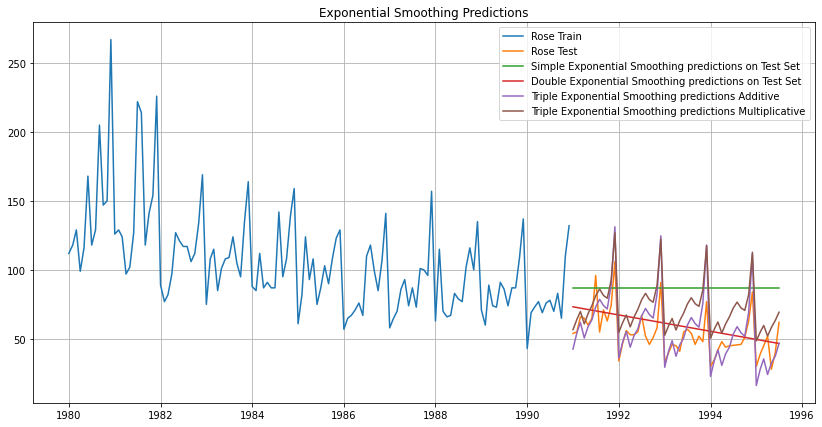

In [35]:
# Forecasting on test set
tes_pred_rose_a = tes_mod_af_rose_a.forecast(steps=len(tes_test_rose))
tes_pred_rose_m = tes_mod_af_rose_m.forecast(steps=len(tes_test_rose))

plt.plot(tes_train_rose, label='Rose Train')
plt.plot(tes_test_rose, label='Rose Test')

plt.plot(test_pred_mod_rose, label='Simple Exponential Smoothing predictions on Test Set')
plt.plot(test_pred_mod2_rose, label='Double Exponential Smoothing predictions on Test Set')
plt.plot(tes_pred_rose_a, label='Triple Exponential Smoothing predictions Additive')
plt.plot(tes_pred_rose_m, label='Triple Exponential Smoothing predictions Multiplicative')

plt.legend(loc='best')
plt.grid()
plt.title('Exponential Smoothing Predictions');

In [36]:
tes_rmse_mod_test_rose_a = metrics.mean_squared_error(tes_test_rose.values,tes_pred_rose_a.values,squared=False)
temp_rw_rmse = pd.DataFrame({'RMSE': [tes_rmse_mod_test_rose_a]},index=['Triple Exponential, Additive'])
rw_rmse = pd.concat([rw_rmse, temp_rw_rmse])

In [37]:
tes_rmse_mod_test_rose_m = metrics.mean_squared_error(tes_test_rose.values,tes_pred_rose_m.values,squared=False)
temp_rw_rmse = pd.DataFrame({'RMSE': [tes_rmse_mod_test_rose_m]},index=['Triple Exponential, Multiplicative'])
rw_rmse = pd.concat([rw_rmse, temp_rw_rmse])
rw_rmse

,RMSE
Linear Regression,15.268955
Naive Model,79.718773
Simple Average,53.460570
2 Point Moving Average,11.529278
4 Point Moving Average,14.451403
6 Point Moving Average,14.566327
9 Point Moving Average,14.727630
"Simple Exponential, Alpha=0.05",36.796227
"Double Exponential, Alpha=0.05",24.998640
"Triple Exponential, Additive",14.257122


### 5. Check for the stationarity of the data on which the model is being built on using appropriate statistical tests and also mention the hypothesis for the statistical test. If the data is found to be non-stationary, take appropriate steps to make it stationary. Check the new data for stationarity and comment.
### Note: Stationarity should be checked at alpha = 0.05.

#### ADF Hypothesis for Rose wines
- H0 : The time series is not stationary
- H1 : The time series is Stationary

In [38]:
from statsmodels.tsa.stattools import adfuller
def test_stat(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, maxlag=12, autolag=None)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput,'\n')

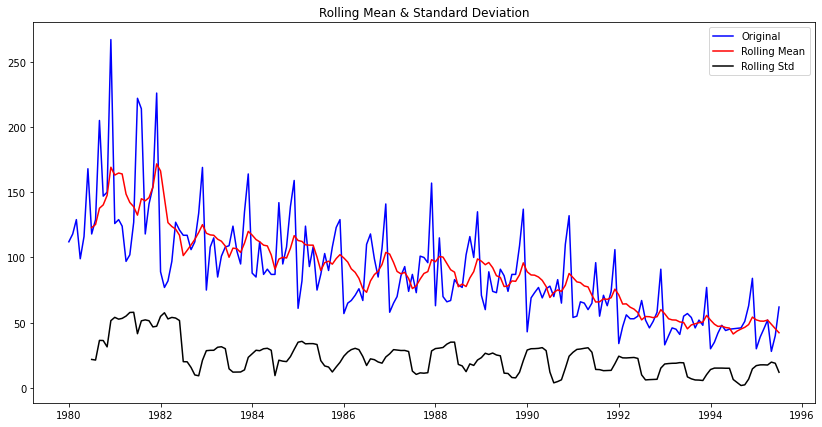

Results of Dickey-Fuller Test:
Test Statistic                  -1.727653
p-value                          0.416924
#Lags Used                      12.000000
Number of Observations Used    174.000000
Critical Value (1%)             -3.468502
Critical Value (5%)             -2.878298
Critical Value (10%)            -2.575704
dtype: float64 



In [39]:
test_stat(dfr_new)

- P value is greater than 0.05 so cannot reject the null hypothesis


We repeat the test again after converting data to log scale

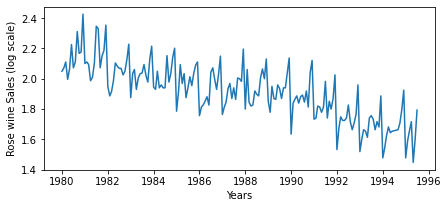

In [40]:
plt.figure(figsize=(7, 3))
plt.plot(np.log10(dfr_new))
plt.xlabel('Years')
plt.ylabel('Rose wine Sales (log scale)');

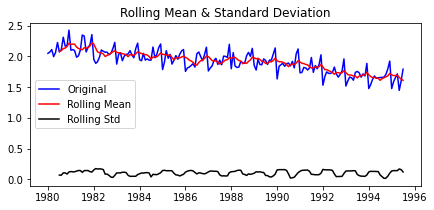

Results of Dickey-Fuller Test:
Test Statistic                  -0.422521
p-value                          0.906270
#Lags Used                      12.000000
Number of Observations Used    174.000000
Critical Value (1%)             -3.468502
Critical Value (5%)             -2.878298
Critical Value (10%)            -2.575704
dtype: float64 



In [41]:
rose1 = np.log10(dfr_new)
rose1.dropna(inplace=True)
plt.figure(figsize=(7, 3))
test_stat(rose1)

- p value is greater than 0.05 so we cannot reject the null hypothesis.

We now differentiate in the order of 1.

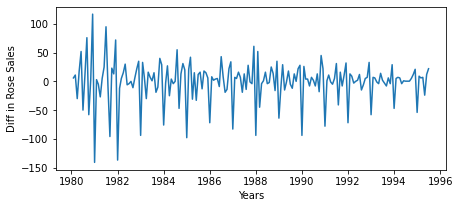

In [42]:
plt.figure(figsize=(7, 3))
plt.plot(dfr_new.diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Diff in Rose Sales');

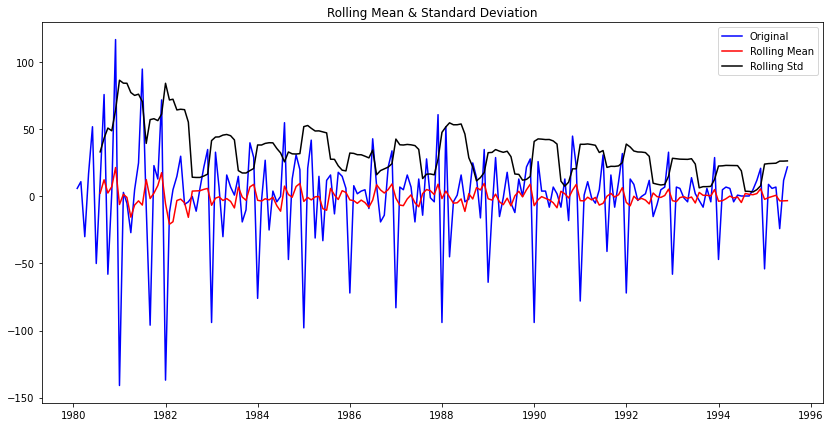

Results of Dickey-Fuller Test:
Test Statistic                -8.044392e+00
p-value                        1.810895e-12
#Lags Used                     1.200000e+01
Number of Observations Used    1.730000e+02
Critical Value (1%)           -3.468726e+00
Critical Value (5%)           -2.878396e+00
Critical Value (10%)          -2.575756e+00
dtype: float64 



In [43]:
rose_2 = dfr_new.diff(periods=1)
rose_2.dropna(inplace=True)
test_stat(rose_2)

- P value is lower than 0.05, hence series has been converted to stationary
### 6.Build an automated version of the ARIMA/SARIMA model in which the parameters are selected using the lowest Akaike Information Criteria (AIC) on the training data and evaluate this model on the test data using RMSE.

In [44]:
import itertools
p = q = range(0, 3)
d = range(0,2) 
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Creating an empty Dataframe with column names only
aic_arima = pd.DataFrame(columns=['param', 'AIC'])
aic_arima_sp = pd.DataFrame(columns=['param', 'AIC'])

#### ARIMA Model

In [45]:
from statsmodels.tsa.arima_model import ARIMA

for param in pdq:
    arima_mod = ARIMA(train_rose, order=param).fit()
    print('ARIMA{} - AIC:{}'.format(param, arima_mod.aic))
    aic_arima = aic_arima.append({'param':param, 'AIC': arima_mod.aic}, ignore_index=True)

aic_arima.sort_values(by='AIC',ascending=True).head()

ARIMA(0, 0, 0) - AIC:1324.8997029577333
ARIMA(0, 0, 1) - AIC:1305.4684057684567
ARIMA(0, 0, 2) - AIC:1306.5866794770002
ARIMA(0, 1, 0) - AIC:1335.1526583086775
ARIMA(0, 1, 1) - AIC:1280.726183046448
ARIMA(0, 1, 2) - AIC:1276.8353734911866
ARIMA(1, 0, 0) - AIC:1301.5463044353048
ARIMA(1, 0, 1) - AIC:1294.510585181333
ARIMA(1, 0, 2) - AIC:1292.0532102469483
ARIMA(1, 1, 0) - AIC:1319.3483105802602
ARIMA(1, 1, 1) - AIC:1277.7757532785026
ARIMA(1, 1, 2) - AIC:1277.359228683666
ARIMA(2, 0, 0) - AIC:1302.3460741769325
ARIMA(2, 0, 1) - AIC:1292.9371945618595
ARIMA(2, 0, 2) - AIC:1292.2480553310668
ARIMA(2, 1, 0) - AIC:1300.6092611744193
ARIMA(2, 1, 1) - AIC:1279.045689409317
ARIMA(2, 1, 2) - AIC:1279.298693936495


,param,AIC
5,"(0, 1, 2)",1276.835373
11,"(1, 1, 2)",1277.359229
10,"(1, 1, 1)",1277.775753
16,"(2, 1, 1)",1279.045689
17,"(2, 1, 2)",1279.298694


In [46]:
# ARIMA (0, 1, 2) has lowest AIC
mod_rose = ARIMA(train_rose, order=(0,1,2))
result_arima_rose = mod_rose.fit()

print(result_arima_rose.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.Rose   No. Observations:                  131
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -634.418
Method:                       css-mle   S.D. of innovations             30.167
Date:                Mon, 21 Feb 2022   AIC                           1276.835
Time:                        22:21:11   BIC                           1288.336
Sample:                    02-01-1980   HQIC                          1281.509
                         - 12-01-1990                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.4886      0.085     -5.742      0.000      -0.655      -0.322
ma.L1.D.Rose    -0.7601      0.101     -7.499      0.000      -0.959      -0.561
ma.L2.D.Rose    -0.2398      0.095     -2.51

In [47]:
fin_hat_avg = test_rose.copy()
pred_rose = result_arima_rose.forecast(steps=55)

rmse = mean_squared_error(test_rose, pred_rose[0], squared=False)
result_arima = pd.DataFrame({'RMSE': [rmse]}, index=['ARIMA (0, 1, 2)'])
result_arima

,RMSE
"ARIMA (0, 1, 2)",15.617834


#### SARIMA Model

In [48]:
aic_sarima = pd.DataFrame(columns=['param','seasonal', 'AIC'])
print(aic_sarima)

import statsmodels.api as sm

for param in pdq:
    for param_seasonal in model_pdq:
        sarima_mod = sm.tsa.statespace.SARIMAX(train_rose,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True,
                                            initialization='approximate_diffuse'
                                            )
        
        result_sarima = sarima_mod.fit()
        print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, result_sarima.aic))
        aic_sarima = aic_sarima.append({'param':param,'seasonal':param_seasonal ,'AIC': result_sarima.aic}, ignore_index=True)

aic_sarima.sort_values(by=['AIC']).head()

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []
SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:1623.1966860123646
SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1546.724986995574
SARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:1519.6662020637714
SARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:1329.914805404443
SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:1332.0506630744198
SARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:1382.2415824651036
SARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:1311.4578365043626
SARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1276.4367118020182
SARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:1339.1741283431415
SARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:1317.0807656135125
SARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:1319.953375903533
SARIMA(0, 0, 0)x(1, 1, 2, 12) - AIC:1374.518976054254
SARIMA(0, 0, 0)x(2, 0, 0, 12) - AIC:1316.0283544342042
SARIMA(0, 0, 0)x(2, 0, 1, 12) - AIC:1317.5518096107994
SARIMA(0, 0, 0)x(2, 0, 2, 12) - AIC:1323.2445249778489
SARIMA(0, 0, 0)x(2, 1, 0, 12) - AIC:1337.497456668838
SARIMA(0, 0, 0)x(2, 1, 1, 12) - AIC:1339.3671154772746
SARIMA(0, 0,

SARIMA(1, 0, 2)x(0, 1, 2, 12) - AIC:1367.9393909076648
SARIMA(1, 0, 2)x(1, 0, 0, 12) - AIC:1290.6765708361172
SARIMA(1, 0, 2)x(1, 0, 1, 12) - AIC:1291.636266534939
SARIMA(1, 0, 2)x(1, 0, 2, 12) - AIC:1337.9047028447621
SARIMA(1, 0, 2)x(1, 1, 0, 12) - AIC:1299.543074519022
SARIMA(1, 0, 2)x(1, 1, 1, 12) - AIC:1298.7291458225955
SARIMA(1, 0, 2)x(1, 1, 2, 12) - AIC:1353.325177348749
SARIMA(1, 0, 2)x(2, 0, 0, 12) - AIC:1306.541600399251
SARIMA(1, 0, 2)x(2, 0, 1, 12) - AIC:1307.707024606505
SARIMA(1, 0, 2)x(2, 0, 2, 12) - AIC:1323.1297210124437
SARIMA(1, 0, 2)x(2, 1, 0, 12) - AIC:1330.0078505080141
SARIMA(1, 0, 2)x(2, 1, 1, 12) - AIC:1327.232383797199
SARIMA(1, 0, 2)x(2, 1, 2, 12) - AIC:1344.0651489576453
SARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:1337.3995337299598
SARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:1349.8710911353019
SARIMA(1, 1, 0)x(0, 0, 2, 12) - AIC:1368.9373928625864
SARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:1377.7640204480972
SARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:1349.02388970612
SARIMA(1, 1, 0)x(0

SARIMA(2, 1, 1)x(1, 1, 2, 12) - AIC:1352.3485686173863
SARIMA(2, 1, 1)x(2, 0, 0, 12) - AIC:1313.1062890053718
SARIMA(2, 1, 1)x(2, 0, 1, 12) - AIC:1314.2951298672397
SARIMA(2, 1, 1)x(2, 0, 2, 12) - AIC:1316.1623867455494
SARIMA(2, 1, 1)x(2, 1, 0, 12) - AIC:1342.2591015526568
SARIMA(2, 1, 1)x(2, 1, 1, 12) - AIC:1338.1360731904424
SARIMA(2, 1, 1)x(2, 1, 2, 12) - AIC:1337.6146394499842
SARIMA(2, 1, 2)x(0, 0, 0, 12) - AIC:1311.1717922238395
SARIMA(2, 1, 2)x(0, 0, 1, 12) - AIC:1331.219650779488
SARIMA(2, 1, 2)x(0, 0, 2, 12) - AIC:1355.1002464222736
SARIMA(2, 1, 2)x(0, 1, 0, 12) - AIC:1331.0835997769104
SARIMA(2, 1, 2)x(0, 1, 1, 12) - AIC:1317.24027516937
SARIMA(2, 1, 2)x(0, 1, 2, 12) - AIC:1374.1160333993828
SARIMA(2, 1, 2)x(1, 0, 0, 12) - AIC:1303.2885058557608
SARIMA(2, 1, 2)x(1, 0, 1, 12) - AIC:1289.2843342706683
SARIMA(2, 1, 2)x(1, 0, 2, 12) - AIC:1340.622319361023
SARIMA(2, 1, 2)x(1, 1, 0, 12) - AIC:1313.7387899780192
SARIMA(2, 1, 2)x(1, 1, 1, 12) - AIC:1310.4193733573443
SARIMA(2, 1, 2

,param,seasonal,AIC
115,"(1, 0, 0)","(1, 0, 1, 12)",1273.600347
7,"(0, 0, 0)","(1, 0, 1, 12)",1276.436712
25,"(0, 0, 1)","(1, 0, 1, 12)",1279.730424
241,"(2, 0, 1)","(1, 0, 1, 12)",1280.695392
223,"(2, 0, 0)","(1, 0, 1, 12)",1281.224095


In [49]:
import statsmodels.api as sm

smod_r = sm.tsa.statespace.SARIMAX(train_rose,
                                order=(1,0,0),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True,
                                initialization='approximate_diffuse')
result_sarima_r = smod_r.fit()
print(result_sarima_r.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 Rose   No. Observations:                  132
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -632.800
Date:                              Mon, 21 Feb 2022   AIC                           1273.600
Time:                                      22:27:04   BIC                           1285.132
Sample:                                  01-01-1980   HQIC                          1278.286
                                       - 12-01-1990                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2004      0.056      3.599      0.000       0.091       0.310
ar.S.L12       0.93

In [50]:
s_pred_r = result_sarima_r.get_forecast(steps=55)
s_pred_r.predicted_mean

from math import sqrt
rmse = sqrt(mean_squared_error(test_rose, s_pred_r.predicted_mean))

temp_result_df = pd.DataFrame({'RMSE': [rmse]}, index=['SARIMA (1, 0, 0) (1, 0, 1, 12)'])
result_arima = pd.concat([result_arima, temp_result_df])
result_arima

,RMSE
"ARIMA (0, 1, 2)",15.617834
"SARIMA (1, 0, 0) (1, 0, 1, 12)",10.375552


### 7. Build ARIMA/SARIMA models based on the cut-off points of ACF and PACF on the training data and evaluate this model on the test data using RMSE.
#### ARIMA model based on cut off points of ACF and PACF in Rose Series

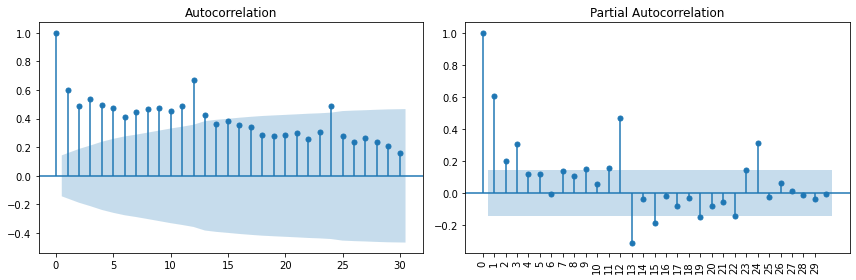

In [51]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
plt.xticks(range(0,30,1), rotation = 90)
smt.graphics.plot_acf(dfr_new, lags=30, ax=axes[0])
smt.graphics.plot_pacf(dfr_new, lags=30, ax=axes[1])
plt.tight_layout()

The lags of ACF and PACF show that the series is not stationary.

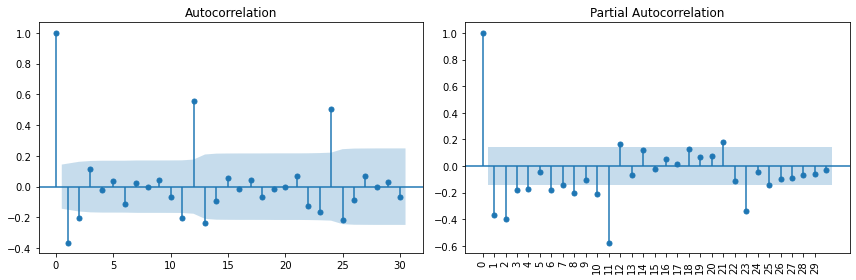

In [52]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
plt.xticks(range(0,30,1), rotation = 90)
smt.graphics.plot_acf(rose_2, lags=30, ax=axes[0])
smt.graphics.plot_pacf(rose_2, lags=30, ax=axes[1])
plt.tight_layout()

- With one differencing, the series has become stationary as checked with the Augmented Dicky Fuller test as well. so d= 1
- So p d q is 5, 1, 3. 

In [53]:
## ARIMA(5,1,3) as per the ACF, PACF cutoffs
mod_r513 = ARIMA(train_rose, order=(5,1,3))

result_arima_r513 = mod_r513.fit()

print(result_arima_r513.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.Rose   No. Observations:                  131
Model:                 ARIMA(5, 1, 3)   Log Likelihood                -629.930
Method:                       css-mle   S.D. of innovations             28.662
Date:                Mon, 21 Feb 2022   AIC                           1279.860
Time:                        22:27:08   BIC                           1308.612
Sample:                    02-01-1980   HQIC                          1291.544
                         - 12-01-1990                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.4934      0.085     -5.817      0.000      -0.660      -0.327
ar.L1.D.Rose    -0.8630      0.092     -9.403      0.000      -1.043      -0.683
ar.L2.D.Rose    -0.7705      0.119     -6.48

In [54]:
final_hat_avg =test_rose.copy()
pred_r513 = result_arima_r513.forecast(steps=55)

from sklearn.metrics import  mean_squared_error
rmse513 = mean_squared_error(test_rose, pred_r513[0],squared=False)

tdf2 = pd.DataFrame({'RMSE': [rmse513]}, index=['ARIMA (5, 1, 3) ACF/PACF Cutoff'])

result_arima = pd.concat([result_arima, tdf2])
result_arima

,RMSE
"ARIMA (0, 1, 2)",15.617834
"SARIMA (1, 0, 0) (1, 0, 1, 12)",10.375552
"ARIMA (5, 1, 3) ACF/PACF Cutoff",15.633261


#### SARIMA model based on cut-off points of ACF & PACF for Rose Series
- p d q is 5, 1, 3.
- P D Q is 1, 1, 0.
- S = 12.

In [55]:
## SARIMA(5, 1, 3)(1, 1, 0, 12)
mod_r22 = sm.tsa.statespace.SARIMAX(train_rose,
                                order=(5,1,3),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
result_sarima_r22 = mod_r22.fit()
print(result_sarima_r22.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                Rose   No. Observations:                  132
Model:             SARIMAX(5, 1, 3)x(1, 1, [], 12)   Log Likelihood                -543.261
Date:                             Mon, 21 Feb 2022   AIC                           1106.521
Time:                                     22:27:12   BIC                           1134.312
Sample:                                 01-01-1980   HQIC                          1117.806
                                      - 12-01-1990                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5614      4.046     -0.139      0.890      -8.492       7.369
ar.L2          0.1425      

In [56]:
pred_r22 = result_sarima_r22.get_forecast(steps=55)
pred_r22.predicted_mean

from math import sqrt
rmse22 = sqrt(mean_squared_error(test_rose, pred_r22.predicted_mean))

tdf3 = pd.DataFrame({'RMSE': [rmse22]}, index=['SARIMA (5, 1, 3) (1, 1, 0)12 ACF/PACF Cutoff'])

result_arima = pd.concat([result_arima, tdf3])
result_arima

,RMSE
"ARIMA (0, 1, 2)",15.617834
"SARIMA (1, 0, 0) (1, 0, 1, 12)",10.375552
"ARIMA (5, 1, 3) ACF/PACF Cutoff",15.633261
"SARIMA (5, 1, 3) (1, 1, 0)12 ACF/PACF Cutoff",17.491317


### 8.	Build a table with all the models built along with their corresponding parameters and the respective RMSE values on the test data.

In [57]:
fin_rmse = pd.concat([rw_rmse, result_arima])
fin_rmse

,RMSE
Linear Regression,15.268955
Naive Model,79.718773
Simple Average,53.460570
2 Point Moving Average,11.529278
4 Point Moving Average,14.451403
6 Point Moving Average,14.566327
9 Point Moving Average,14.727630
"Simple Exponential, Alpha=0.05",36.796227
"Double Exponential, Alpha=0.05",24.998640
"Triple Exponential, Additive",14.257122


### 9. Based on the model-building exercise, build the most optimum model(s) on the complete data and predict 12 months into the future with appropriate confidence intervals/bands.

The SARIMA(1, 0, 0)(1, 0, 1,12) model has the lowest RMSE. We use it to predict the future sales.

                                      SARIMAX Results                                       
Dep. Variable:                                 Rose   No. Observations:                  187
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -841.170
Date:                              Mon, 21 Feb 2022   AIC                           1690.341
Time:                                      22:27:13   BIC                           1703.265
Sample:                                  01-01-1980   HQIC                          1695.578
                                       - 07-01-1995                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2105      0.042      4.989      0.000       0.128       0.293
ar.S.L12       0.92

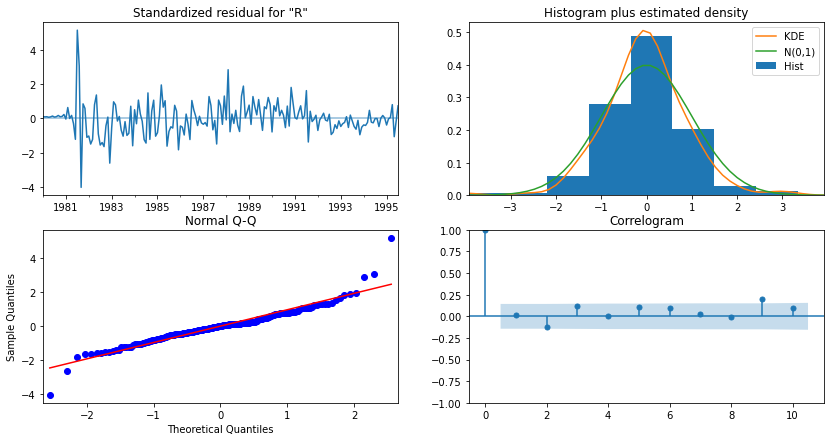

In [58]:
# SARIMA(1, 0, 0)(1, 0, 1,12)
mod_r = sm.tsa.statespace.SARIMAX(dfr,
                                order=(1,0,0),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True,
                                initialization='approximate_diffuse')
best_results = mod_r.fit()
print(best_results.summary())

best_results.plot_diagnostics(figsize=(14, 7))
plt.show()

In [59]:
# For the next 12 months for Rose series
n_steps = 12
pred_u_99 = best_results.get_forecast(steps=n_steps, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_u_95 = best_results.get_forecast(steps=n_steps, alpha=0.05) # alpha=0.05 signifies 95% confidence interval

pred_c_99 = pred_u_99.conf_int()
pred_c_95 = pred_u_95.conf_int()

idx = pd.date_range(dfr_new.index[-1], periods=n_steps, freq='MS')

fc_95 = pd.DataFrame(np.column_stack([ pred_u_95.predicted_mean,  pred_c_95]), index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([pred_c_99]), index=idx, columns=['lower_ci_99', 'upper_ci_99'])

fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] 

fc_all

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
1995-07-01,56.134718,23.371222,88.898213,23.371222,88.898213
1995-08-01,50.885430,17.404428,84.366431,17.404428,84.366431
1995-09-01,48.816168,15.303735,82.328602,15.303735,82.328602
1995-10-01,56.131900,22.618076,89.645725,22.618076,89.645725
1995-11-01,77.005373,43.491486,110.519259,43.491486,110.519259
1995-12-01,33.637041,0.123152,67.150930,0.123152,67.150930
1996-01-01,37.810550,4.359270,71.261829,4.359270,71.261829
1996-02-01,41.283518,7.835015,74.732022,7.835015,74.732022
1996-03-01,35.509307,2.060926,68.957687,2.060926,68.957687
1996-04-01,40.057600,6.609225,73.505975,6.609225,73.505975


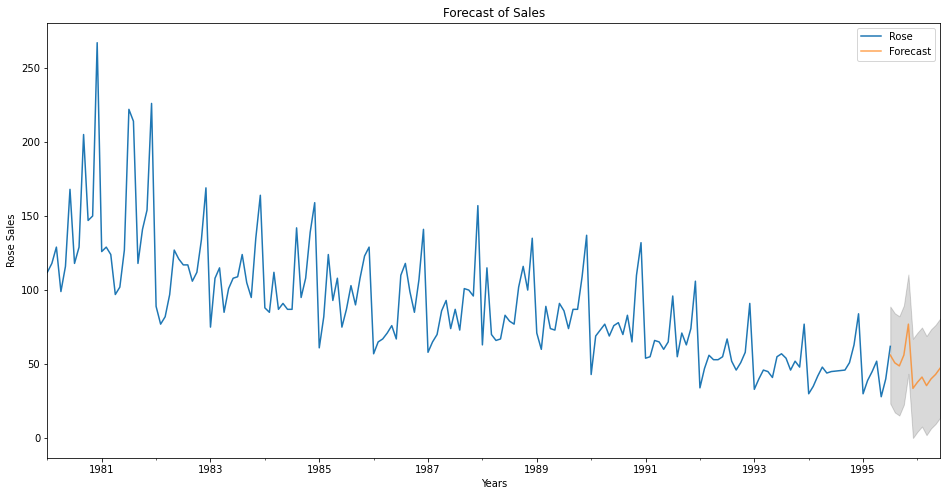

In [60]:
axis = dfr_new.plot(label='Observed', figsize=(16, 8))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.15)

axis.set_xlabel('Years')
axis.set_ylabel('Rose Sales')
plt.legend(loc='best')

plt.title("Forecast of Sales")
plt.show()

### 10.	Comment on the model thus built and report your findings and suggest the measures that the company should be taking for future sales.

- We have predicted the future sales for 12 months for Rose Wines.
- Based on the model, we can observe that the macro trend for Sales of Rose Wines is declining.
- My suggestion would be to slowly ramp down production of Rose Wines.
- The company can perform market research to identify other products which have an increasing macro trend, and then explore selling other products.